In [1]:
%reset -f

In [2]:
#@title Autoload all modules
%load_ext autoreload
%autoreload 2

from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import io
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import importlib
import os
import functools
import itertools
import torch
from losses import get_optimizer
from models.ema import ExponentialMovingAverage

import torch.nn as nn
from torch.utils import tensorboard
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import tqdm
import io
import likelihood
import controllable_generation
from utils import restore_checkpoint
sns.set(font_scale=2)
sns.set(style="whitegrid")

import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization
import sampling
from likelihood import get_likelihood_fn
from sde_lib import VESDE, VPSDE, subVPSDE
from sampling import (ReverseDiffusionPredictor, 
                      LangevinCorrector, 
                      EulerMaruyamaPredictor, 
                      AncestralSamplingPredictor, 
                      NoneCorrector, 
                      NonePredictor,
                      AnnealedLangevinDynamics)
import datasets
import losses
from time import time

from torchvision.utils import make_grid, save_image
from utils import save_checkpoint, restore_checkpoint

import run_lib
from absl import app
from absl import flags
from ml_collections.config_flags import config_flags
import logging

import jax

import inspect

C:\Users\rrazafin\AppData\Local\anaconda3\envs\py38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\rrazafin\AppData\Local\anaconda3\envs\py38\lib\site-packages\torch\utils\cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


### Dataset

CelebFaces Attributes dataset contains 202599 face images (with values $\in [0,255]$) of the size 178×218.

In [3]:
DATA_DIR = "celeba_dataset/"

class CelebA(tfds.image.celeba.CelebA):
  def _split_generators(self, dl_manager):
    
    downloaded_dirs = {
      "img_align_celeba": DATA_DIR + "img_align_celeba.zip",
      "list_eval_partition": DATA_DIR + "list_eval_partition.txt",
      "list_attr_celeba": DATA_DIR + "list_attr_celeba.txt",
      "landmarks_celeba": DATA_DIR + "list_landmarks_align_celeba.txt",
    }

    # Load all images in memory (~1 GiB)
    # Use split to convert: `img_align_celeba/000005.jpg` -> `000005.jpg`
    all_images = {
        os.path.split(k)[-1]: img
        for k, img in dl_manager.iter_archive(
            downloaded_dirs["img_align_celeba"]
        )
    }

    return [
        tfds.core.SplitGenerator(
            name=tfds.Split.TRAIN,
            gen_kwargs={
                "file_id": 0,
                "downloaded_dirs": downloaded_dirs,
                "downloaded_images": all_images,
            },
        ),
        tfds.core.SplitGenerator(
            name=tfds.Split.VALIDATION,
            gen_kwargs={
                "file_id": 1,
                "downloaded_dirs": downloaded_dirs,
                "downloaded_images": all_images,
            },
        ),
        tfds.core.SplitGenerator(
            name=tfds.Split.TEST,
            gen_kwargs={
                "file_id": 2,
                "downloaded_dirs": downloaded_dirs,
                "downloaded_images": all_images,
            },
        ),
    ]



In [16]:
def get_data_scaler(config):
  """Data normalizer. Assume data are always in [0, 1]."""
  if config.data.centered:
    # Rescale to [-1, 1]
    return lambda x: x * 2. - 1.
  else:
    return lambda x: x


def get_data_inverse_scaler(config):
  """Inverse data normalizer."""
  if config.data.centered:
    # Rescale [-1, 1] to [0, 1]
    return lambda x: (x + 1.) / 2.
  else:
    return lambda x: x



def resize_small(image, resolution):
  """Shrink an image to the given resolution."""
  image = tf.convert_to_tensor(image)
  h, w = image.shape[0], image.shape[1]
  ratio = resolution / min(h, w)
  h = tf.round(h * ratio) # h = tf.round(h * ratio, tf.int32)
  w = tf.round(w * ratio) # w = tf.round(w * ratio, tf.int32)
  return tf.image.resize(image, [h, w], antialias=True)


def central_crop(image, size):
  """Crop the center of an image to the given size."""
  top = (image.shape[0] - size) // 2
  left = (image.shape[1] - size) // 2
  return tf.image.crop_to_bounding_box(image, top, left, size, size)

def get_dataset(config, uniform_dequantization=False, evaluation=False):
  """Create data loaders for training and evaluation.

  Args:
    config: A ml_collection.ConfigDict parsed from config files.
    uniform_dequantization: If `True`, add uniform dequantization to images.
    evaluation: If `True`, fix number of epochs to 1.

  Returns:
    train_ds, eval_ds, dataset_builder.
  """

  batch_size = config.training.batch_size if not evaluation else config.eval.batch_size
  if batch_size % jax.device_count() != 0:
    raise ValueError(f'Batch sizes ({batch_size} must be divided by'
                     f'the number of devices ({jax.device_count()})')

  shuffle_buffer_size = 10000
  prefetch_size = tf.data.experimental.AUTOTUNE
  num_epochs = None if not evaluation else 1



  dataset_builder = CelebA() # tfds.builder('celeb_a')
  train_split_name = 'train'
  eval_split_name = 'validation'

  def resize_op(img):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = central_crop(img, 140)
    img = resize_small(img, config.data.image_size)
    return img

  # Customize preprocess functions for each dataset.

  def preprocess_fn(d):
    """Basic preprocessing function scales data to [0, 1) and randomly flips."""
    img = resize_op(d['image'])
    if config.data.random_flip and not evaluation:
       img = tf.image.random_flip_left_right(img)
    if uniform_dequantization:
       img = (tf.random.uniform(img.shape, dtype=tf.float32) + img * 255.) / 256.

    return dict(image=img, label=d.get('label', None))

  def create_dataset(dataset_builder, split):
    dataset_options = tf.data.Options()
    dataset_options.experimental_optimization.map_parallelization = True
    dataset_options.experimental_threading.private_threadpool_size = 48
    dataset_options.experimental_threading.max_intra_op_parallelism = 1
    read_config = tfds.ReadConfig(options=dataset_options)
    if isinstance(dataset_builder, tfds.core.DatasetBuilder):
      dataset_builder.download_and_prepare()
      ds = dataset_builder.as_dataset(
        split=split, shuffle_files=True, read_config=read_config)
    else:
      ds = dataset_builder.with_options(dataset_options)
    

    # Get a sample from the dataset
    iter = ds.as_numpy_iterator()
    sample = next(iter)
    print(sample['image'].shape)
      
    plt.imshow(sample['image'])
    plt.axis("off")
    plt.title(f'Sample from {split} set.')
    plt.show()
      
    # for element in ds: print(element['image'])
    
    ds = ds.repeat(count=num_epochs)
    ds = ds.shuffle(shuffle_buffer_size)
    ds = ds.map(preprocess_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=True)
    return ds.prefetch(prefetch_size)

  train_ds = create_dataset(dataset_builder, train_split_name)
  eval_ds = create_dataset(dataset_builder, eval_split_name)
  return train_ds, eval_ds, dataset_builder


In [13]:
from configs.ve import celeba_ncsnpp as configs
config = configs.get_config()
print(config)

data:
  centered: false
  dataset: CELEBA
  image_size: 64
  num_channels: 3
  random_flip: true
  uniform_dequantization: false
device: !!python/object/apply:torch.device
- cuda
- 0
eval:
  batch_size: 1024
  begin_ckpt: 1
  bpd_dataset: test
  enable_bpd: false
  enable_loss: true
  enable_sampling: true
  end_ckpt: 26
  num_samples: 50000
model:
  attention_type: ddpm
  attn_resolutions: !!python/tuple
  - 16
  beta_max: 20.0
  beta_min: 0.1
  ch_mult: !!python/tuple
  - 1
  - 2
  - 2
  - 2
  conditional: true
  conv_size: 3
  dropout: 0.1
  ema_rate: 0.999
  embedding_type: positional
  fir: true
  fir_kernel:
  - 1
  - 3
  - 3
  - 1
  init_scale: 0.0
  name: ncsnpp
  nf: 128
  nonlinearity: swish
  normalization: GroupNorm
  num_res_blocks: 4
  num_scales: 1000
  progressive: none
  progressive_combine: sum
  progressive_input: residual
  resamp_with_conv: true
  resblock_type: biggan
  scale_by_sigma: true
  sigma_begin: 90
  sigma_max: 90.0
  sigma_min: 0.01
  skip_rescale: true

In [14]:
## Update config

config.training.batch_size = 64 # Memory usage.
config.training.snapshot_sampling = True # Default: True. False if no sampling during training.

ok
(218, 178, 3)


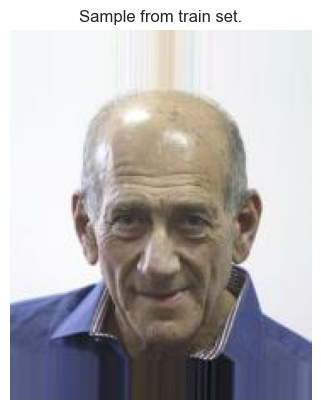

(218, 178, 3)


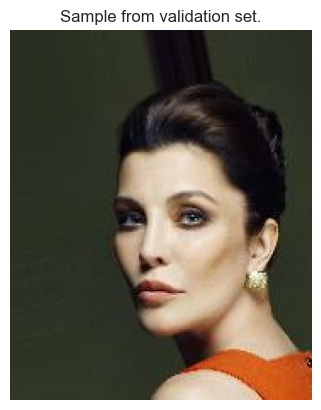

In [15]:
train_ds, eval_ds, _ = get_dataset(config, uniform_dequantization=config.data.uniform_dequantization)
train_iter = iter(train_ds)
eval_iter = iter(eval_ds)

Preprocessed sample, $\mathbf{x} \in [0,1]^{64 \times 64 \times 3}$.

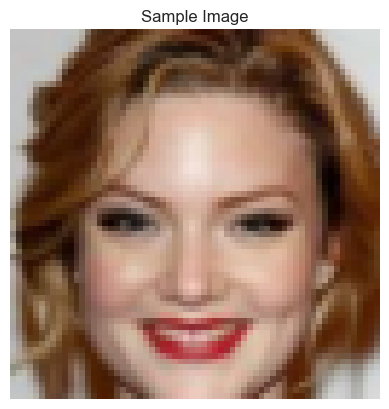

(64, 64, 3)


In [8]:
sample = next(train_iter)
batch = sample['image']
plt.imshow(batch[0])
plt.title('Sample Image')
plt.axis('off')
plt.show()
print(batch[0].shape)

Recommended settings:

 | dataset | SDE | predictor | corrector | snr | n_steps |
|:----:|:----:|:----------:|:--------:|:---:|:----:|
|CIFAR-10 | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.16| 1|
|CIFAR-10 | VP | EulerMaruyamaPredictor | None | - | - |
|CIFAR-10 | subVP| EulerMaruyamaPredictor | None | - | - |
| LSUN/CelebA-HQ/FFHQ 256px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.075 | 1 |
| FFHQ 1024px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.15| 1 |

Check `probability_flow` to run PC sampling based on discretizing the probability flow ODE.

# Training

There are no restrictions on the network architecture of time-dependent score-based models, except that their output should have the same dimensionality as the input, and they should be conditioned on time.




Several useful tips on architecture choice:
* It usually performs well to use the [U-net](https://arxiv.org/abs/1505.04597) architecture as the backbone of the score network $s_\theta(\mathbf{x}, t)$. The architecture here is mostly based on Ho et al. (2020). The score-based model for VE SDEs uses the following techniques

1. Upsampling and downsampling images with anti-aliasing based on Finite Impulse Response (FIR) (Zhang, 2019). We follow the same implementation and hyper-parameters in StyleGAN-2 (Karras et al., 2020b).

2. Rescaling all skip connections by 1/√2. This has been demonstrated effective in several best-in-class GAN models, including ProgressiveGAN (Karras et al., 2018), StyleGAN (Karras et al., 2019) and StyleGAN-2 (Karras et al., 2020b).

3. Replacing the original residual blocks in DDPM with residual blocks from BigGAN (Brock et al., 2018).

4. Increasing the number of residual blocks per resolution from 2 to 4.

5. Incorporating progressive growing architectures. We consider two progressive architectures for input: "input skip" and "residual", and two progressive architectures for output: "output skip" and "residual". These progressive architectures are defined and implemented according to StyleGAN-2.

* We can incorporate the time information via [Gaussian random features](https://arxiv.org/abs/2006.10739). Specifically, we first sample $\omega \sim \mathcal{N}(\mathbf{0}, s^2\mathbf{I})$ which is subsequently fixed for the model (i.e., not learnable). For a time step $t$, the corresponding Gaussian random feature is defined as 
\begin{align}
  [\sin(2\pi \omega t) ; \cos(2\pi \omega t)],
\end{align}
where $[\vec{a} ; \vec{b}]$ denotes the concatenation of vector $\vec{a}$ and $\vec{b}$. This Gaussian random feature can be used as an encoding for time step $t$ so that the score network can condition on $t$ by incorporating this encoding.

* We can rescale the output of the U-net by $1/\sqrt{\mathbb{E}[\|\nabla_{\mathbf{x}}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0)) \|_2^2]}$. This is because the optimal $s_\theta(\mathbf{x}(t), t)$ has an $\ell_2$-norm close to $\mathbb{E}[\|\nabla_{\mathbf{x}}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))]\|_2$, and the rescaling helps capture the norm of the true score. Recall that the training objective contains sums of the form
\begin{align*}
\mathbf{E}_{\mathbf{x}(t) \sim p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))}[ \|s_\theta(\mathbf{x}(t), t) - \nabla_{\mathbf{x}(t)}\log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))\|_2^2].
\end{align*}
Therefore, it is natural to expect that the optimal score model $s_\theta(\mathbf{x}, t) \approx \nabla_{\mathbf{x}(t)} \log p_{0t}(\mathbf{x}(t) \mid \mathbf{x}(0))$.

* Use [exponential moving average](https://discuss.pytorch.org/t/how-to-apply-exponential-moving-average-decay-for-variables/10856/3) (EMA) of weights when sampling. This can greatly improve sample quality, but requires slightly longer training time, and requires more work in implementation. It is highly recommended if you employ score-based generative modeling to tackle challenging real problems.

<details>
  <summary>Click to expand </summary>
    
**Exponential Moving Average (EMA) Algorithm**
=============================================

**Initialization**
---------------

* Initialize the EMA parameters $\theta_0^{ema}$ with the same shape as the model parameters $\theta$
* Initialize the decay rate $\alpha_0 \in (0, 1)$ (usually 0.999 for VE perturbations, or 0.9999 for VP perturbations)
* Initialize the number of updates $t = 0$

**Update Rule**
-------------

* For each update $t$ and model parameters $\theta_t$:
    + Update the decay $\alpha_t = \min(\alpha_{t-1}, \frac{1+t}{10+t})$ (or not)
    + Update the EMA parameters $\theta_{t}^{ema} = \alpha_t \theta_{t-1}^{ema} + (1 - \alpha_t) \theta_{t-1}$
    + Increment the number of updates $t = t + 1$

**Sampling**
---------

* To sample from the EMA model, use the EMA parameters $\theta_t^{ema}$ as the model parameters.

**Note:** If updated, $(\alpha_{t \geq 1})$ increases over the time so the more $t$ increases, the more $\alpha_t$ is close to $1$ and then the update of $\theta^{ema}$ is slow due to the diminishing contribution of the new parameter $\theta$ values. The behavior of the weights $\alpha_t$ is the reason the moving average is called exponential.
</details>

In [9]:
# Initialize the model
score_model = mutils.create_model(config) # NCSN++
ema = ExponentialMovingAverage(score_model.parameters(), decay=config.model.ema_rate) # ema_rate (decay) = 0.999
optimizer = losses.get_optimizer(config, score_model.parameters()) # Adam
state = dict(optimizer=optimizer, model=score_model, ema=ema, step=0)

In [10]:
# Checkpoints directory
workdir = ""
checkpoint_dir = os.path.join(workdir, "checkpoints")

# Intermediate checkpoints to resume training after pre-emption in cloud environments
checkpoint_meta_dir = os.path.join(workdir, "checkpoints-meta", "checkpoint.pth")

# Create the directories
tf.io.gfile.makedirs(checkpoint_dir)
tf.io.gfile.makedirs(os.path.dirname(checkpoint_meta_dir))

# Resume training when intermediate checkpoints are detected
state = restore_checkpoint(checkpoint_meta_dir, state, config.device)
initial_step = int(state['step'])

sample_dir = os.path.join(workdir, "samples")
tf.io.gfile.makedirs(sample_dir)

tb_dir = os.path.join(workdir, "tensorboard")
tf.io.gfile.makedirs(tb_dir)
writer = tensorboard.SummaryWriter(tb_dir)

In [11]:
train_iter = iter(train_ds)

# Create data normalizer and its inverse. Here scaler is identity function so the values remain in [0,1] (not [-1,1]).
scaler = datasets.get_data_scaler(config) # identity
inverse_scaler = datasets.get_data_inverse_scaler(config) # identity

In [12]:
# config.training.sde.lower() == 'vesde'
sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
sampling_eps = 1e-5

In [13]:
# Build one-step training and evaluation functions
optimize_fn = losses.optimization_manager(config) # Manage how to perform optimization steps (including warmup and gradient clipping) 
continuous = config.training.continuous # False. The model does not take continuous time steps.
reduce_mean = config.training.reduce_mean # False. If True, average the loss across data dimensions. Otherwise sum the loss across data dimensions.
likelihood_weighting = config.training.likelihood_weighting # False. The model uses the weighting of the score-matching loss recommended by the paper.
train_step_fn = losses.get_step_fn(sde, train=True, optimize_fn=optimize_fn,
                                     reduce_mean=reduce_mean, continuous=continuous,
                                     likelihood_weighting=likelihood_weighting)
eval_step_fn = losses.get_step_fn(sde, train=False, optimize_fn=optimize_fn,
                                    reduce_mean=reduce_mean, continuous=continuous,
                                    likelihood_weighting=likelihood_weighting)

In [14]:
sampling_shape = (1, config.data.num_channels,
                      config.data.image_size, config.data.image_size) # (config.training.batch_size, 3, 64, 64)

sampling_fn = sampling.get_sampling_fn(config, sde, sampling_shape, inverse_scaler, sampling_eps)
# Predictor-Corrector Sampler.
# Predictor: Reverse diffusion sampler
# Corrector: Annelealed Langevin Dynamics.

In [15]:
num_train_steps = config.training.n_iters # 1300001

In [16]:
print("Frequence of saving state and sampling:", config.training.snapshot_freq)
print("Frequence of displaying training loss:", config.training.log_freq)
print("Frequence of displaying evaluation loss:", config.training.eval_freq)

Frequence of saving state and sampling: 50000
Frequence of displaying training loss: 50
Frequence of displaying evaluation loss: 100


### Training steps

In [17]:
for step in range(initial_step, num_train_steps + 1):
    # Convert data to torch tensors and normalize them. Use ._numpy() to avoid copy.
    batch = torch.from_numpy(next(train_iter)['image']._numpy()).to(config.device).float()
    batch = batch.permute(0, 3, 1, 2)
    batch = scaler(batch)
    # Execute one training step ( ~ compute loss, loss.backward(), optimizer.step() + EMA update).
    # EMA updates the moving average of the new parameters of the step, stored as s_params.
    loss = train_step_fn(state, batch)
    
    if step % config.training.log_freq == 0:
        print("step: %d, training_loss: %.5e" % (step, loss.item())) # logging.info("step: %d, training_loss: %.5e" % (step, loss.item()))
      # writer.add_scalar("training_loss", loss, step)

    # Save a temporary checkpoint to resume training after pre-emption periodically.
    if step != 0 and step % config.training.snapshot_freq_for_preemption == 0:
      save_checkpoint(checkpoint_meta_dir, state)

    # Report the loss on an evaluation dataset periodically.
    if step % config.training.eval_freq == 0:
      eval_batch = torch.from_numpy(next(eval_iter)['image']._numpy()).to(config.device).float()
      eval_batch = eval_batch.permute(0, 3, 1, 2)
      eval_batch = scaler(eval_batch)
      eval_loss = eval_step_fn(state, eval_batch)
      print("step: %d, eval_loss: %.5e" % (step, eval_loss.item())) # logging.info()
      # writer.add_scalar("eval_loss", eval_loss.item(), step)

    # Save a checkpoint periodically and generate samples if needed.
    if step != 0 and step % config.training.snapshot_freq == 0 or step == num_train_steps:
      # Save the checkpoint.
      save_step = step // config.training.snapshot_freq
      save_checkpoint(os.path.join(checkpoint_dir, f'checkpoint_{save_step}.pth'), state)
      print(f"Checkpoint saved into the file checkpoint_{save_step}.pth.")
      # Generate and save samples
      if config.training.snapshot_sampling:
        print(f"Sampling.")
        # We want to use the moving average of the parameters for validation/sampling, without affecting the original optimization process.
        ema.store(score_model.parameters()) # Save the current parameters for restoring later.
        ema.copy_to(score_model.parameters()) # Copies the current moving average of the parameters (shadow_params) to the input parameters.
        sample, n = sampling_fn(score_model) 
        ema.restore(score_model.parameters()) # Restore the parameters stored with the `store` method.
        this_sample_dir = os.path.join(sample_dir, "iter_{}".format(step))
        tf.io.gfile.makedirs(this_sample_dir)
        nrow = int(np.sqrt(sample.shape[0]))
        image_grid = make_grid(sample, nrow, padding=2)
        sample = np.clip(sample.permute(0, 2, 3, 1).cpu().numpy() * 255, 0, 255).astype(np.uint8)
        with tf.io.gfile.GFile(
            os.path.join(this_sample_dir, "sample.np"), "wb") as fout:
          np.save(fout, sample)

        with tf.io.gfile.GFile(
            os.path.join(this_sample_dir, "sample.png"), "wb") as fout:
          save_image(image_grid, fout)

step: 0, training_loss: 6.13364e+03
step: 0, eval_loss: 6.11221e+03
step: 50, training_loss: 6.10027e+03
step: 100, training_loss: 5.94584e+03
step: 100, eval_loss: 5.98156e+03
step: 150, training_loss: 5.62752e+03
step: 200, training_loss: 5.14090e+03
step: 200, eval_loss: 5.33623e+03
step: 250, training_loss: 4.57713e+03
step: 300, training_loss: 3.90149e+03
step: 300, eval_loss: 4.27165e+03
step: 350, training_loss: 3.14473e+03
step: 400, training_loss: 2.42590e+03
step: 400, eval_loss: 2.94821e+03
step: 450, training_loss: 1.77617e+03
step: 500, training_loss: 1.24492e+03
step: 500, eval_loss: 1.68561e+03
step: 550, training_loss: 6.73385e+02
step: 600, training_loss: 6.34810e+02
step: 600, eval_loss: 7.46637e+02
step: 650, training_loss: 4.41765e+02
step: 700, training_loss: 4.03972e+02
step: 700, eval_loss: 3.45953e+02
step: 750, training_loss: 4.23353e+02
step: 800, training_loss: 3.27519e+02
step: 800, eval_loss: 4.19726e+02
step: 850, training_loss: 4.04790e+02
step: 900, trai

KeyboardInterrupt: 

# Sampling

### Load checkpoint of the model

In [3]:
from configs.ve import celebahq_256_ncsnpp_continuous as configs
ckpt_filename = "exp/ve/celebahq_256_ncsnpp_continuous/checkpoint_48.pth"
config = configs.get_config()
sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
sampling_eps = 1e-5 # for VE sde, 1e-3 otherwise

batch_size = 1
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0

sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
score_model = mutils.create_model(config)

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

In [4]:
def image_grid(x):
  size = config.data.image_size
  channels = config.data.num_channels
  img = x.reshape(-1, size, size, channels)
  w = int(np.sqrt(img.shape[0]))
  img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
  return img

def show_samples(x):
  x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
  img = image_grid(x)
  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

Let consider the forward SDE
\begin{equation}
dx = \underbrace{f(x, t)}_{\text{drift}}dt + \underbrace{g(t)}_{\text{diffusion coef}}dw,
\end{equation}
Then
Reverse SDE (`probability_flow = False`):
\begin{equation}
dx = \underbrace{[f(x,t) - g(t)^2 \nabla_x \log p_{t}(x)]}_{\text{drift}}dt + \underbrace{g(t)}_{\text{diffusion coef}}d\bar{w}
\end{equation}
Reverse Probability flow ODE (`probability_flow = True`):
\begin{equation*}
dx = \underbrace{\left[ f(x,t) - \frac{1}{2} g(t)^2 \nabla_x \log p_t(x) \right]}_{\text{drift}}dt
\end{equation*}


### Drift and diffusion coef choices

<table>
    <tr>
        <th>$f(\mathbf{x},t)$</th>
        <th>$g(t)$</th>
        <th>Type</th>
        <th>$\mathbf{\Sigma}(t) = \text{Cov}[x(t)]$</th>
        <th>Note</th>
    </tr>
    <tr>
        <td>$-\frac{1}{2} \beta(t) \mathbf{x}$</td>
        <td>$\sqrt{\beta(t)}$</td>
        <td>VP</td>
        <td>$\mathbf{I} + e^{\int_0^t -\beta(s) \, ds} \left( \mathbf{\Sigma}(0) - \mathbf{I} \right)$</td>
        <td>Constant unit variance if the initial distribution has unit variance.</td>
    </tr>
    <tr>
        <td>$-\frac{1}{2} \left( \bar{\beta}_{\text{min}} + t(\bar{\beta}_{\text{max}} - \bar{\beta}_{\text{min}}) \right) \mathbf{x}$</td>
        <td>$\sqrt{\bar{\beta}_{\text{min}} + t(\bar{\beta}_{\text{max}} - \bar{\beta}_{\text{min}})}$</td>
        <td>VP</td>
        <td></td>
        <td>Disctretization of this yields to DDPM.</td>
    </tr>
    <tr>
        <td>$-\frac{1}{2} \beta(t) \mathbf{x}$</td>
        <td>$\sqrt{\beta(t) \left( 1 - e^{-2 \int_0^t \beta(s) \, ds} \right)}$</td>
        <td>sub-VP</td>
        <td>$\mathbf{I} + e^{-2 \int_0^t \beta(s) \, ds} \mathbf{I} + e^{\int_0^t \beta(s) \, ds} \left( \mathbf{\Sigma}(0) - 2\mathbf{I} \right)$</td>
        <td>Better FID and NLL than its counterpart (VP) on CIFAR-10, and $\mathbf{\Sigma}_{\text{sub-VP}}(t) \preceq \mathbf{\Sigma}_{\text{VP}}(t)$.

 </td>
    </tr>
    <tr>
        <td>$0$</td>
        <td>$\sqrt{\frac{\text{d}[\sigma^2(t)]}{\text{d}t}}$</td>
        <td>VE</td>
        <td></td>
        <td>Exploding variance when $t \rightarrow \infty$.</td>
    </tr>
    <tr>
        <td>$0$</td>
        <td>$\sigma^t$</td>
        <td>VE</td>
        <td></td>
        <td>Particular case with $\sigma(t) = \sqrt{\frac{1}{2\log \sigma}(\sigma^{2t} - 1)}$</td>
    </tr>
    <tr>
        <td>$0$</td>
        <td>$\sigma_{\text{min}} \left( \frac{\sigma_{\text{max}}}{\sigma_{\text{min}}} \right)^t \sqrt{2 \log \frac{\sigma_{\text{max}}}{\sigma_{\text{min}}}}$</td>
        <td>VE</td>
        <td></td>
        <td>Discretization of this is named SMLD (?).</td>
    </tr>
</table>


### Predictor Corrector sampling

### Predictors
**Euler Maruyama**:
\begin{align}
\mathbf{x}_{t-\Delta t} = \mathbf{x}_t + g^2(t) s_\theta(\mathbf{x}_t, t)\Delta t + g(t)\sqrt{\Delta t} \mathbf{z}_t
\end{align}
where $\mathbf{z}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.

**Ancestral Sampling (only supports VP and VE SDE)**:

VP:
\begin{equation}
\mathbf{x}_{i-1} = \frac{1}{\sqrt{1 - \beta_i}} \left( \mathbf{x}_i + \beta_i s_\theta(\mathbf{x}_i, i) \right) + \sqrt{\beta_i} \mathbf{z}_i
\end{equation}
VE:
\begin{equation}
\mathbf{x}_{i-1} = \mathbf{x}_i + \left( \sigma_i^2 - \sigma_{i-1}^2 \right) s_\theta(\mathbf{x}_i, i) + \sqrt{\frac{\sigma_{i-1}^2 (\sigma_i^2 - \sigma_{i-1}^2)}{\sigma_i^2}} \mathbf{z}_i
\end{equation}

*Example: DDPM.*

**Reverse Diffusion**:

Based on the discretized forward iteration rule

\begin{equation}
\mathbf{x}_{i+1} = \mathbf{x}_i + \mathbf{f}_i(\mathbf{x}_i) + \mathbf{G}_i \mathbf{z}_i
\end{equation}

the sampling iteration rule is
\begin{equation}
\mathbf{x}_i = \mathbf{x}_{i+1} - \underbrace{\left[\mathbf{f}_{i+1}(\mathbf{x}_{i+1}) - \mathbf{G}_{i+1} \mathbf{G}_{i+1}^\top s_\theta^*(\mathbf{x}_{i+1}, i + 1)\right]}_{\text{reverse} f} + \underbrace{\mathbf{G}_{i+1}}_{\text{reverse } G} \mathbf{z}_{i+1}
\end{equation}

**None/Identity**:

*Example: SMLD.*

### Correctors

**Re-framed Annealed Langevin Dynamics** (named Langevin corrector):

\begin{equation}
\mathbf{x'}_{t} = \mathbf{x}_{t} + \frac{\epsilon}{2} \mathbf{g} + \sqrt{2\epsilon} \mathbf{z}_{t}
\end{equation}

with $g =  s_\theta(\mathbf{x}_{t}, t)$ and $\epsilon = 2\alpha_t r \frac{\| \mathbf{z} \|_2}{\| \mathbf{g} \|_2}$ is the step size. 

For VP:
\begin{equation*}
\alpha_t = 1 - \beta_t
\end{equation*}

For VE:
\begin{equation*}
\alpha_t = 1
\end{equation*}

*Example: SMLD*.

**Annealed Langevin Dynamics**:

\begin{equation}
\mathbf{x'}_{t} = \mathbf{x}_{t} + \frac{\epsilon}{2} \mathbf{g} + \sqrt{2\epsilon} \mathbf{z}_{t}
\end{equation}

with $g =  s_\theta(\mathbf{x}_{t}, t)$ and $\epsilon = 2\alpha_t r$ is the step size. 

For VP:
\begin{equation*}
\alpha_t = 1 - \beta_t
\end{equation*}

For VE:
\begin{equation*}
\alpha_t = 1
\end{equation*}

*Example: SMLD*.

**None/Identity**:

*Example: DDPM.*

### Observation on CIFAR-10

Reverse diffusion sampler always outperform ancestral sampling, and corrector-only
methods perform worse than other competitors with the same computation
(In fact, we need way more corrector steps per noise scale, and thus more computation, to match the
performance of other samplers.) For all predictors, adding one corrector step for each predictor step
(PC1000) doubles computation but always improves sample quality.

In [5]:
img_size = config.data.image_size
channels = config.data.num_channels
shape = (batch_size, channels, img_size, img_size)
predictor = ReverseDiffusionPredictor # ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector # ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16
n_steps =  1
probability_flow = False # true => no diffusion coefficient, only drift
sampling_fn = sampling.get_pc_sampler(sde, shape, predictor, corrector,
                                      inverse_scaler, snr, n_steps=n_steps,
                                      probability_flow=probability_flow,
                                      continuous=config.training.continuous,
                                      eps=sampling_eps, device=config.device)

In [ ]:
%%time
x, n = sampling_fn(score_model.to(config.device))
show_samples(x)

 96%|██████████████████████████████████████████████████████████████████████████▍   | 1910/2000 [13:00<00:36,  2.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [12:12<00:00,  2.73it/s]


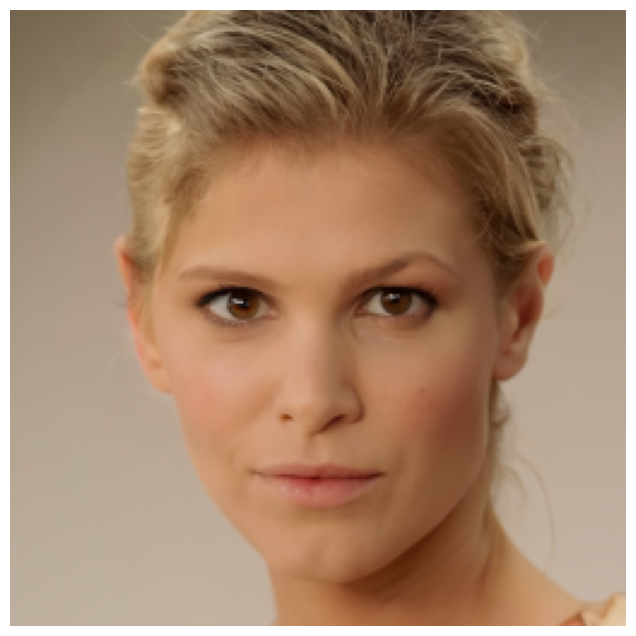

CPU times: total: 12min 6s
Wall time: 12min 13s


In [6]:
%%time
x, n = sampling_fn(score_model.to(config.device))
show_samples(x)

### Training